# RFM Segmentation in E-Commerce

RFM segmentation is a well-known user segmentation strategy based on three user characteristics:<br>
Recency (R): When was the user’s most recent transaction?<br>
Frequency (F): How often does the customer transact?<br>
Monetary (M): What is the size of the user’s transaction?

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

In [2]:
#imorting the data
RFM_data=pd.read_csv('retailerdata.csv', encoding= 'unicode_escape')

In [3]:
RFM_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
RFM_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
#finding any missing values
RFM_data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
#droping null values
RFM_data = RFM_data.dropna(axis = 0)

In [7]:
#checking duplicates values
RFM_data.duplicated().sum()

5225

In [8]:
# droping duplicates
RFM_data = RFM_data.drop_duplicates(ignore_index = True)

# Feature engineering

In [9]:
# convert datetime column format
RFM_data.InvoiceDate = pd.to_datetime(RFM_data.InvoiceDate)

# create new column of Total_Sales
RFM_data['Total_Sales'] = RFM_data.Quantity * RFM_data.UnitPrice

# include only positive Total_Sales values(exclude credit)
RFM_data = RFM_data[RFM_data['Total_Sales'] > 0]

#Convert Data Type of column CustomerID float into integer
RFM_data['CustomerID'] = RFM_data['CustomerID'].astype('Int64')

Recency is the last transaction or recent transaction done by the customer

In [10]:
# recency (r)
data_r = RFM_data[['InvoiceDate','CustomerID']].groupby('CustomerID')['InvoiceDate'].agg('max').reset_index()
data_r.head()

,CustomerID,InvoiceDate
0,12346,2011-01-18 10:01:00
1,12347,2011-12-07 15:52:00
2,12348,2011-09-25 13:13:00
3,12349,2011-11-21 09:51:00
4,12350,2011-02-02 16:01:00


In [11]:
data_r.shape

(4338, 2)

we set it as the most recent value of InvoiceData column.

In [12]:
# current time reference
cur_time = data_r.InvoiceDate.max()
# month diff function
def month_diff(cur_time, datetime_val): 
    return 12 * (cur_time.year - datetime_val.year) + (cur_time.month - datetime_val.month)
# recency month
data_r['Recency'] = data_r.InvoiceDate.apply(lambda datetime_val: month_diff(cur_time, datetime_val))

In [13]:
#set the recency last 6 month
data_r.Recency = data_r.Recency.clip(lower = None, upper = 6)
# drop InvoiceDate column
data_r = data_r.drop('InvoiceDate', axis = 1)
# head
data_r.head()

,CustomerID,Recency
0,12346,6
1,12347,0
2,12348,3
3,12349,1
4,12350,6


Frequency is the how many times a customer transact<br>
Monetary is the how amount the customer has transact

In [14]:
# frequency & monetary(fm) df only w.r.t. last 6 months data
EARLIEST_DATE = pd.to_datetime('2011-06-09')
data_fm = RFM_data[RFM_data.InvoiceDate >= EARLIEST_DATE]
data_fm = data_fm[['InvoiceNo','CustomerID','Total_Sales']]
data_fm = data_fm.groupby('CustomerID')[['InvoiceNo','Total_Sales']].agg({'InvoiceNo':'nunique', 'Total_Sales':'mean'}).reset_index()
data_fm = data_fm.rename(columns = {'InvoiceNo':'Frequency', 'Total_Sales':'Monetary'})
data_fm.Monetary = data_fm.Monetary.round(2)
data_fm.head()

,CustomerID,Frequency,Monetary
0,12347,4,25.37
1,12348,1,103.33
2,12349,1,24.08
3,12352,3,20.09
4,12356,1,29.17


In [15]:
#Merging the Recency and Frequency, Monetory Data
data = data_r.merge(data_fm, on = 'CustomerID', how = 'left')
data = data.fillna(0)
data.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,6,0.0,0.00
1,12347,0,4.0,25.37
2,12348,3,1.0,103.33
3,12349,1,1.0,24.08
4,12350,6,0.0,0.00


# Model Training

Standardizing the data because the value of Monetory is measure in money to insure the that K-means algorithm does not overvaule the monetory function

In [16]:
from sklearn.preprocessing import StandardScaler
# feature columns
feature_cols = ['Recency','Frequency','Monetary']
# standardized df for training
standardized_data = data.copy()
# standardization
scaler = StandardScaler()
scaler.fit(data[feature_cols])
standardized_features = scaler.transform(data[feature_cols])
standardized_data[feature_cols] = standardized_features

# Eblow Method

The Elbow method is a common way to choose K optimally

In [17]:
# fit K-means clustering on various Ks
from sklearn.cluster import KMeans
kmeans_kwargs = {
    "init" : "random",
    "n_init" : 10
}
sse = []
#Elbow Method Function
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(standardized_data[feature_cols])
    sse.append(kmeans.inertia_)

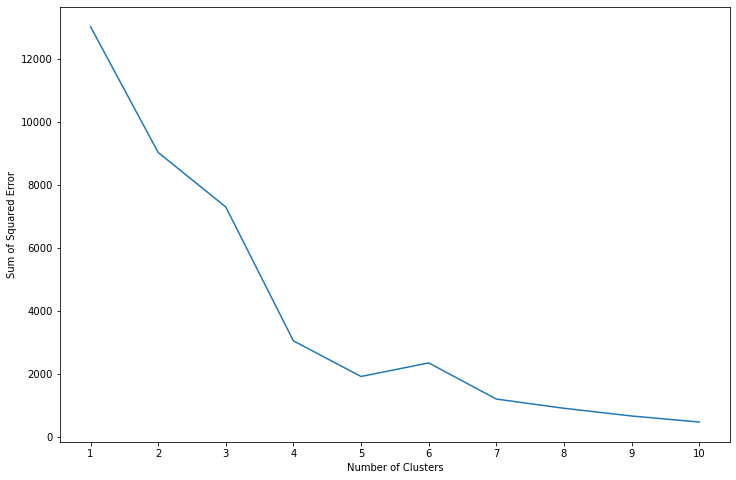

In [18]:
# Elbow method plot
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Error")
plt.show()

In [25]:
kmeans_kwargs = {
    "init" : "random",
    "n_init" : 10
}
# run kmeans with the optimal k
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(standardized_data[feature_cols])
data['cluster'] = kmeans.labels_
data.head()

,CustomerID,Recency,Frequency,Monetary,cluster
0,12346,6,0.0,0.00,1
1,12347,0,4.0,25.37,2
2,12348,3,1.0,103.33,2
3,12349,1,1.0,24.08,2
4,12350,6,0.0,0.00,1


In [26]:
# look at the centroids per cluster
centroid_df = data.groupby('cluster')[['Recency', 'Frequency', 'Monetary','CustomerID']].agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary':'mean','CustomerID':'nunique'}).reset_index()
centroid_df = centroid_df.rename(columns = {'CustomerID':'NumBuyers'})
centroid_df

,cluster,Recency,Frequency,Monetary,NumBuyers
0,0,0.166667,25.712121,2636.807576,66
1,1,5.555718,0.493402,24.198798,1364
2,2,1.316713,2.873796,30.930024,2908


According to the table above, we have three user clusters/segments<br><br>
Cluster 0: Our top segment of users. Users in this category are recent/current regular buyers (recency low, frequency high). Their most recent transaction was only a few days ago, with a frequency of 26 transactions in the previous six months. Unfortunately, there are just a handful of them (66 users, equivalent to 1.5 percent of all user base).<br><br>
Cluster 1: Our churned segment of users. Users in this category are our opt-out customers (recency high , frequency low). Their last transaction was more than five months ago, with just 0 or 1 transaction in the previous six months! They are also, unfortunately, many (1364 users, equivalent to 31.5 percent of all user base).<br><br>
Cluster 2: Our casual segment of users. Users in this category are our regular customers (modest on both recency and frequency). Their most recent transaction was within the last two months, with a frequency of up to three transactions in the previous six months. They are, as is widely observed, the largest portion of our user base (2908 users, equivalent to 67 percent of all user base).

In [27]:
#give high-level name for each cluster
centroid_df.pop('cluster')
cluster_names = ['Top Buyers','Churned Buyers','Casual Buyers']
centroid_df['ClusterName'] = cluster_names
centroid_df

,Recency,Frequency,Monetary,NumBuyers,ClusterName
0,0.166667,25.712121,2636.807576,66,Top Buyers
1,5.555718,0.493402,24.198798,1364,Churned Buyers
2,1.316713,2.873796,30.930024,2908,Casual Buyers
